Instantiate the Xception model

In [1]:
from keras.applications import Xception
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

83683744/83683744 [==============================] - 524s 6us/step


Architecture of the Xception convolutional base

In [2]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

Fast Feature Extraction without Data Augmentation

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) 
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 413ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 461ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 460ms/step


The extracted features are currently of shape (samples, 5, 5, 2048). Feed them to a densely connected classifier, First flatten them (samples, 51200)

In [4]:
train_features = np.reshape(train_features, (2000, 5*5* 2048))
validation_features = np.reshape(validation_features, (1000, 5*5* 2048))
test_features = np.reshape(test_features, (1000, 5*5* 2048))

Define densely connected classifier (the use of dropout for regularization) and train it on the data and labels

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=5 * 5 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [7]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 11s 105ms/step - loss: 0.1517 - acc: 0.9325 - val_loss: 0.0956 - val_acc: 0.9680
Epoch 2/30
100/100 [==============================] - 11s 105ms/step - loss: 0.0735 - acc: 0.9780 - val_loss: 0.0945 - val_acc: 0.9650
Epoch 3/30
100/100 [==============================] - 11s 106ms/step - loss: 0.0478 - acc: 0.9800 - val_loss: 0.0906 - val_acc: 0.9700
Epoch 4/30
100/100 [==============================] - 11s 109ms/step - loss: 0.0340 - acc: 0.9870 - val_loss: 0.0926 - val_acc: 0.9670
Epoch 5/30
100/100 [==============================] - 10s 105ms/step - loss: 0.0204 - acc: 0.9935 - val_loss: 0.1056 - val_acc: 0.9660
Epoch 6/30
100/100 [==============================] - 10s 104ms/step - loss: 0.0145 - acc: 0.9965 - val_loss: 0.1059 - val_acc: 0.9650
Epoch 7/30
100/100 [==============================] - 10s 105ms/step - loss: 0.0093 - acc: 0.9980 - val_loss: 0.1072 - val_acc: 0.9640
Epoch 8/30
100/100 [==============================] - 1

The loss and accuracy curves during training.

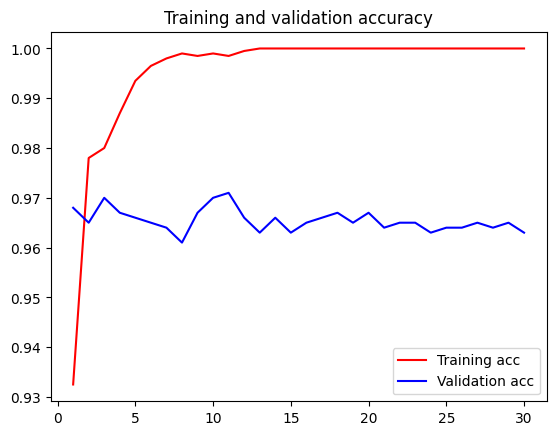

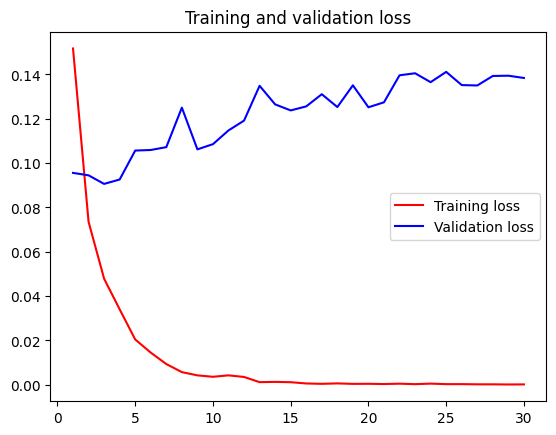

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Overfitted! (from the beginning - 2nd epoch) need data augmentation, due to the small dataset.

Calculating Accuracy, Precision, Recall, and F1-score

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicting on test data
test_predictions = model.predict(test_features)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=['Cat', 'Dog']))


32/32 [==============================] - 0s 9ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.97      0.97      0.97       500
         Dog       0.97      0.97      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



Generating the Confusion Matrix

Confusion Matrix:
[[486  14]
 [ 14 486]]


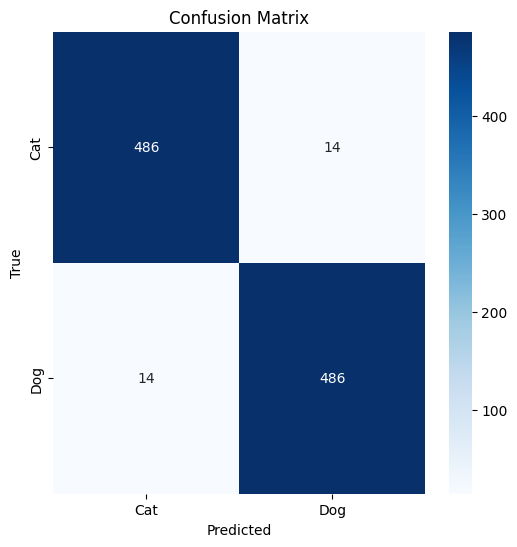

In [10]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Feature Extraction with Data Augmentation

In [1]:
from keras.applications import Xception
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [2]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 33969193 (129.58 MB)
Trainable params: 33914665 (129.37 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


Freeze the convolutional base

In [4]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 158
This is the number of trainable weights after freezing the conv base: 4


Start training model, with the data-augmentation configuration

In [5]:
import os
import numpy as np

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=2e-5), metrics=['acc'])

In [8]:
from keras.callbacks import EarlyStopping

# Implementing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [9]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[early_stopping])


Epoch 1/30
100/100 [==============================] - 76s 746ms/step - loss: 0.2695 - acc: 0.8815 - val_loss: 0.1899 - val_acc: 0.9350
Epoch 2/30
100/100 [==============================] - 81s 813ms/step - loss: 0.1803 - acc: 0.9250 - val_loss: 0.1219 - val_acc: 0.9520
Epoch 3/30
100/100 [==============================] - 85s 849ms/step - loss: 0.1580 - acc: 0.9355 - val_loss: 0.0836 - val_acc: 0.9620
Epoch 4/30
100/100 [==============================] - 82s 823ms/step - loss: 0.1425 - acc: 0.9395 - val_loss: 0.0885 - val_acc: 0.9630
Epoch 5/30
100/100 [==============================] - 83s 829ms/step - loss: 0.1426 - acc: 0.9415 - val_loss: 0.0892 - val_acc: 0.9600
Epoch 6/30
100/100 [==============================] - 83s 833ms/step - loss: 0.1172 - acc: 0.9510 - val_loss: 0.0823 - val_acc: 0.9640
Epoch 7/30
100/100 [==============================] - 84s 845ms/step - loss: 0.1244 - acc: 0.9525 - val_loss: 0.1005 - val_acc: 0.9570
Epoch 8/30
100/100 [==============================] - 8

Plot the results

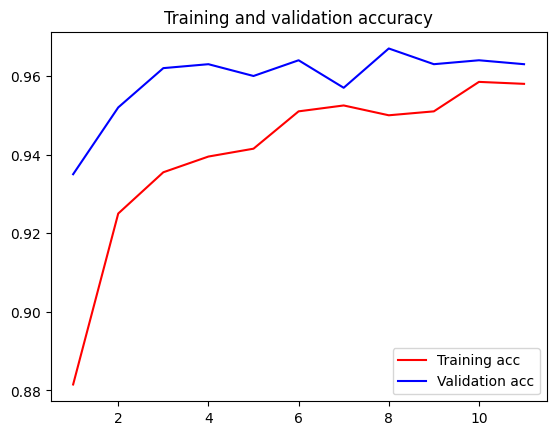

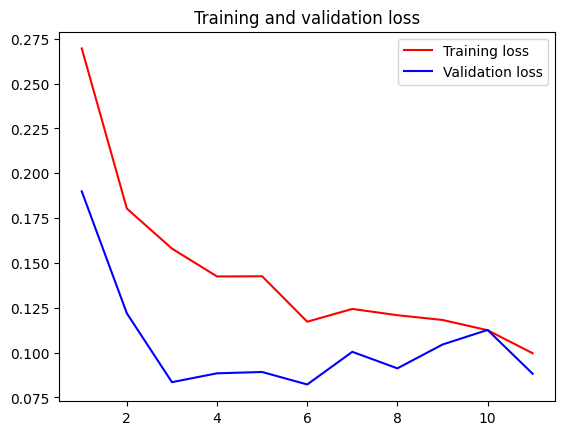

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Accuracy and loss much better than the previous model.

Calculating Accuracy, Precision, Recall, and F1-score

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)  # Important: shuffle=False to match predictions with labels

# Predicting on test data
test_steps = test_generator.samples // test_generator.batch_size
test_predictions = model.predict(test_generator, steps=test_steps)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions, target_names=['Cat', 'Dog']))


Found 1000 images belonging to 2 classes.
50/50 [==============================] - 21s 419ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.96      0.98      0.97       500
         Dog       0.98      0.95      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



Generating the Confusion Matrix

Confusion Matrix:
[[491   9]
 [ 23 477]]


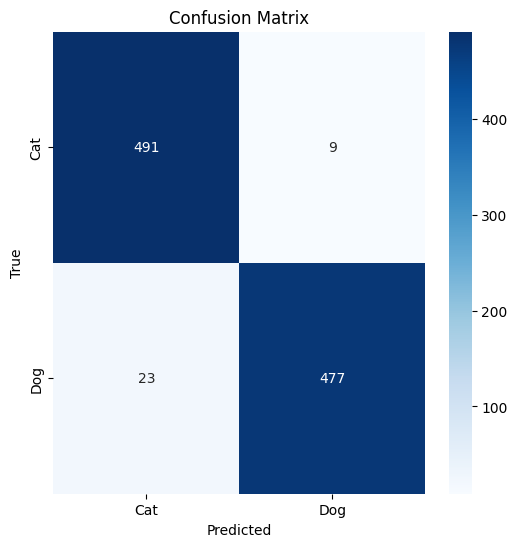

In [12]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Fine Tuning

In [1]:
from keras.applications import Xception
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [2]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 33969193 (129.58 MB)
Trainable params: 33914665 (129.37 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


Fine-tune only the top two or three layers in the convolutional base

In [4]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block14_sepconv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Begin fine-tuning the network

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-5), metrics=['acc'])


In [8]:
from keras.callbacks import EarlyStopping

# Implementing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [9]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[early_stopping])


Epoch 1/30
100/100 [==============================] - 101s 981ms/step - loss: 0.3184 - acc: 0.8680 - val_loss: 0.1767 - val_acc: 0.9330
Epoch 2/30
100/100 [==============================] - 115s 1s/step - loss: 0.2271 - acc: 0.8955 - val_loss: 0.0895 - val_acc: 0.9620
Epoch 3/30
100/100 [==============================] - 121s 1s/step - loss: 0.1973 - acc: 0.9120 - val_loss: 0.0916 - val_acc: 0.9640
Epoch 4/30
100/100 [==============================] - 116s 1s/step - loss: 0.1828 - acc: 0.9250 - val_loss: 0.1043 - val_acc: 0.9570
Epoch 5/30
100/100 [==============================] - 116s 1s/step - loss: 0.1750 - acc: 0.9265 - val_loss: 0.0898 - val_acc: 0.9640
Epoch 6/30
100/100 [==============================] - 116s 1s/step - loss: 0.1507 - acc: 0.9380 - val_loss: 0.0854 - val_acc: 0.9630
Epoch 7/30
100/100 [==============================] - 115s 1s/step - loss: 0.1551 - acc: 0.9355 - val_loss: 0.0840 - val_acc: 0.9630
Epoch 8/30
100/100 [==============================] - 116s 1s/step

Getting curves

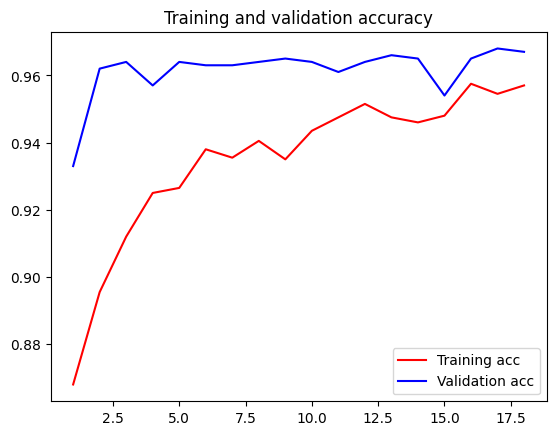

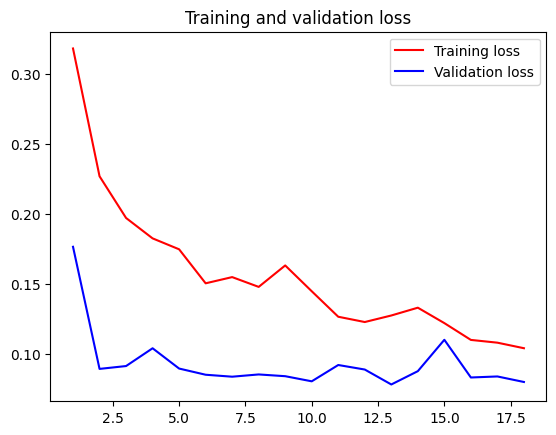

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Smoothing curves

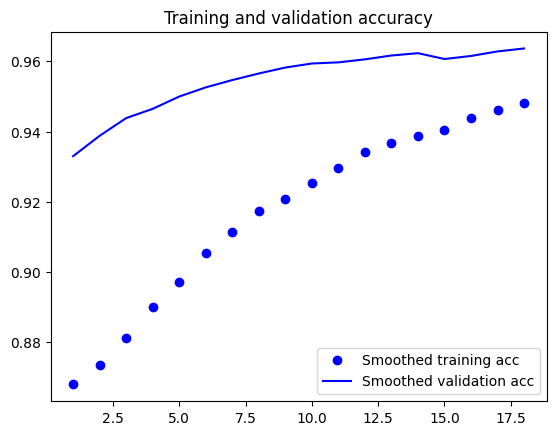

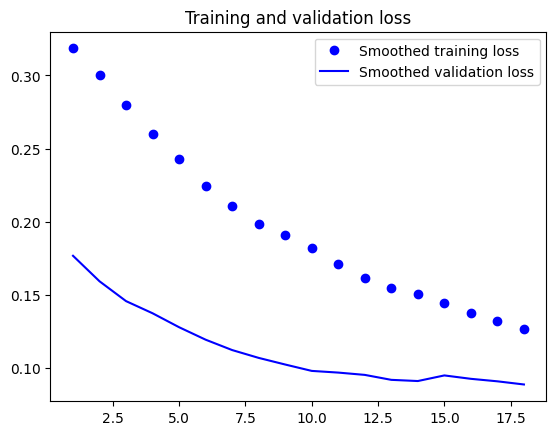

In [11]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting smoothed training and validation accuracy
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plotting smoothed training and validation loss
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

# Display the plots
plt.show()

Evaluate this model on the test data

In [12]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)

print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 24s 473ms/step - loss: 0.0917 - acc: 0.9720
test acc: 0.972000002861023


Calculating Accuracy, Precision, Recall, and F1-score

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)  # Important: shuffle=False to match predictions with labels

# Predicting on test data
test_steps = test_generator.samples // test_generator.batch_size
test_predictions = model.predict(test_generator, steps=test_steps)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions, target_names=['Cat', 'Dog']))


Found 1000 images belonging to 2 classes.
50/50 [==============================] - 25s 492ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.97      0.98      0.97       500
         Dog       0.98      0.97      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



Generating the Confusion Matrix

Confusion Matrix:
[[489  11]
 [ 17 483]]


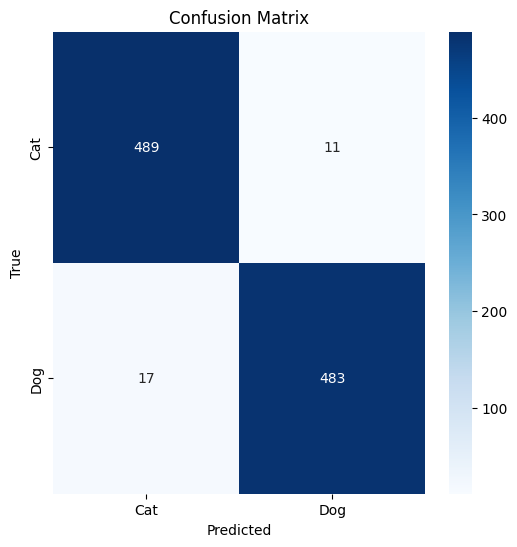

In [14]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Fine Tuning - 2

In [1]:
from keras.applications import Xception
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [2]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 33969193 (129.58 MB)
Trainable params: 33914665 (129.37 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [4]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block12_sepconv1_act':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-5), metrics=['acc'])


In [8]:
from keras.callbacks import EarlyStopping

# Implementing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [9]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[early_stopping])


Epoch 1/30
100/100 [==============================] - 121s 1s/step - loss: 0.4037 - acc: 0.8290 - val_loss: 0.1110 - val_acc: 0.9510
Epoch 2/30
100/100 [==============================] - 122s 1s/step - loss: 0.2328 - acc: 0.9085 - val_loss: 0.0957 - val_acc: 0.9580
Epoch 3/30
100/100 [==============================] - 124s 1s/step - loss: 0.2194 - acc: 0.9155 - val_loss: 0.0932 - val_acc: 0.9630
Epoch 4/30
100/100 [==============================] - 125s 1s/step - loss: 0.1938 - acc: 0.9255 - val_loss: 0.0946 - val_acc: 0.9660
Epoch 5/30
100/100 [==============================] - 124s 1s/step - loss: 0.1669 - acc: 0.9315 - val_loss: 0.0976 - val_acc: 0.9660
Epoch 6/30
100/100 [==============================] - 124s 1s/step - loss: 0.1752 - acc: 0.9265 - val_loss: 0.1038 - val_acc: 0.9660
Epoch 7/30
100/100 [==============================] - 124s 1s/step - loss: 0.1533 - acc: 0.9380 - val_loss: 0.1023 - val_acc: 0.9610
Epoch 8/30
100/100 [==============================] - 125s 1s/step - 

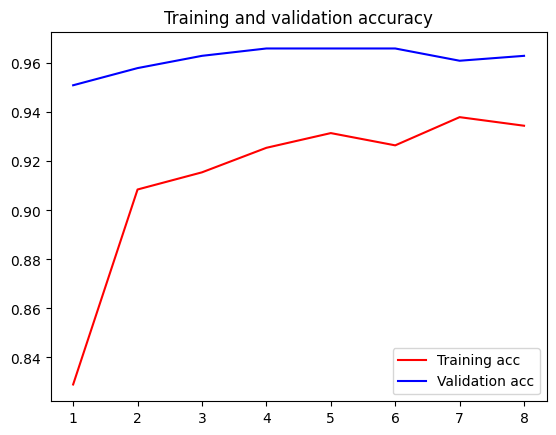

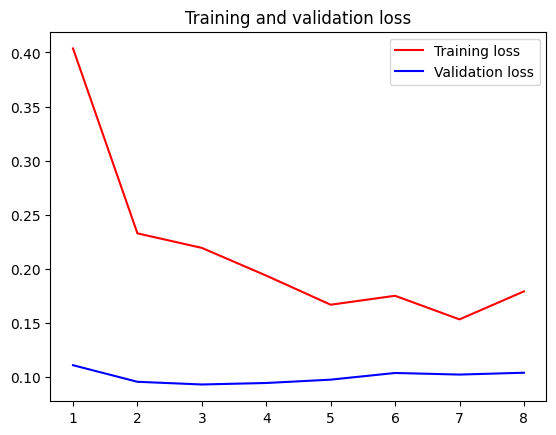

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

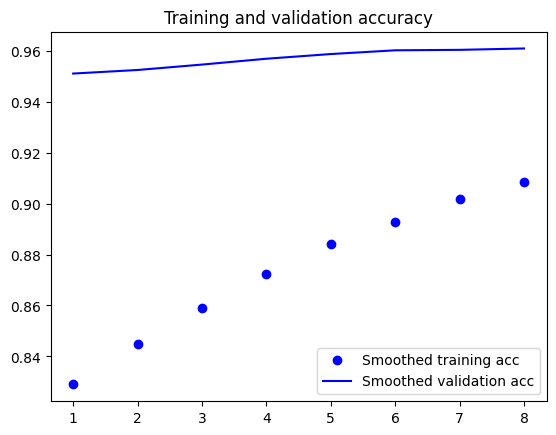

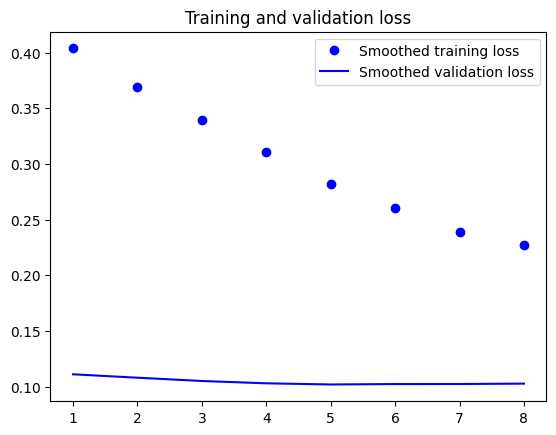

In [11]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting smoothed training and validation accuracy
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plotting smoothed training and validation loss
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

# Display the plots
plt.show()

In [12]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)

print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 20s 405ms/step - loss: 0.0987 - acc: 0.9660
test acc: 0.9660000205039978


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)  # Important: shuffle=False to match predictions with labels

# Predicting on test data
test_steps = test_generator.samples // test_generator.batch_size
test_predictions = model.predict(test_generator, steps=test_steps)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions, target_names=['Cat', 'Dog']))


Found 1000 images belonging to 2 classes.
50/50 [==============================] - 21s 416ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.97      0.96      0.97       500
         Dog       0.96      0.97      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



Confusion Matrix:
[[482  18]
 [ 16 484]]


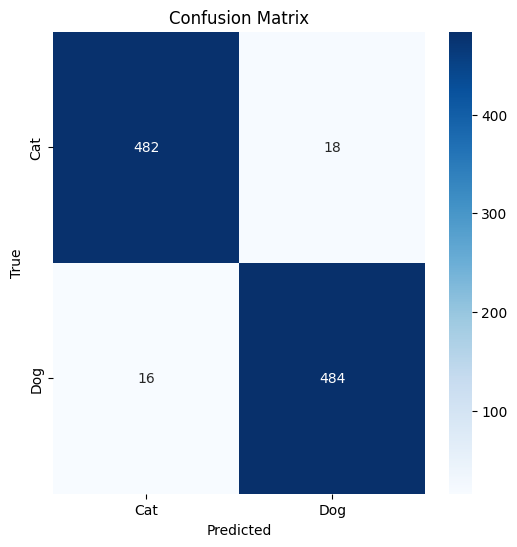

In [14]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Fine Tuning - 3

In [1]:
from keras.applications import Xception
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [2]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

In [3]:
from keras import models, layers, optimizers, regularizers

# Model definition
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 33969193 (129.58 MB)
Trainable params: 33914665 (129.37 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [5]:
# Unfreezing layers of the MobileNet model
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block10_sepconv1_act':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [7]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

In [9]:
from keras.callbacks import EarlyStopping

# Implementing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [10]:
# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[early_stopping])


Epoch 1/30
100/100 [==============================] - 144s 1s/step - loss: 0.9871 - acc: 0.7675 - val_loss: 0.6179 - val_acc: 0.9520
Epoch 2/30
100/100 [==============================] - 158s 2s/step - loss: 0.8202 - acc: 0.8635 - val_loss: 0.6169 - val_acc: 0.9510
Epoch 3/30
100/100 [==============================] - 157s 2s/step - loss: 0.7539 - acc: 0.8895 - val_loss: 0.6391 - val_acc: 0.9520
Epoch 4/30
100/100 [==============================] - 160s 2s/step - loss: 0.7648 - acc: 0.8905 - val_loss: 0.6149 - val_acc: 0.9570
Epoch 5/30
100/100 [==============================] - 159s 2s/step - loss: 0.7266 - acc: 0.9015 - val_loss: 0.6121 - val_acc: 0.9550
Epoch 6/30
100/100 [==============================] - 155s 2s/step - loss: 0.7056 - acc: 0.9185 - val_loss: 0.6079 - val_acc: 0.9570
Epoch 7/30
100/100 [==============================] - 156s 2s/step - loss: 0.6984 - acc: 0.9180 - val_loss: 0.6018 - val_acc: 0.9610
Epoch 8/30
100/100 [==============================] - 163s 2s/step - 

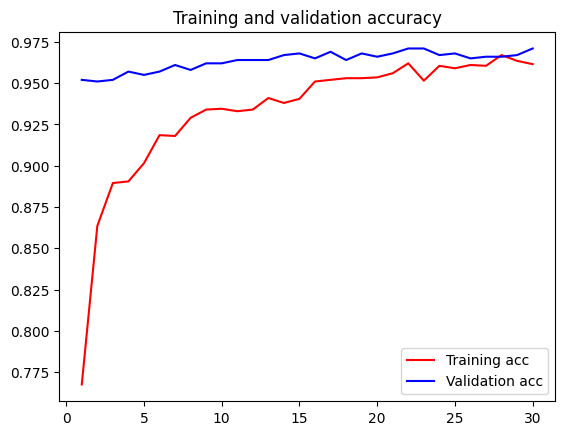

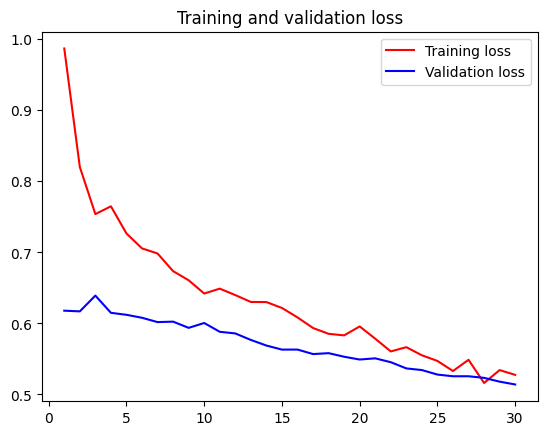

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

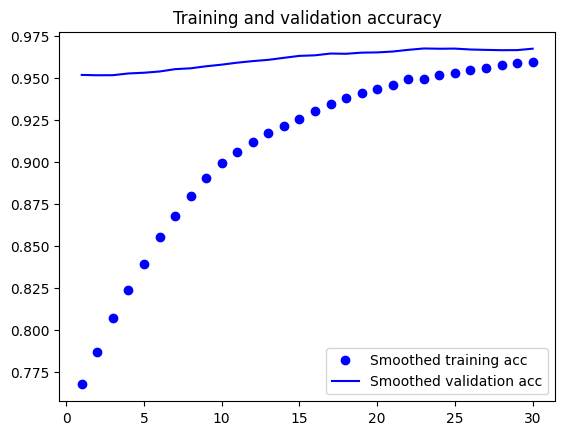

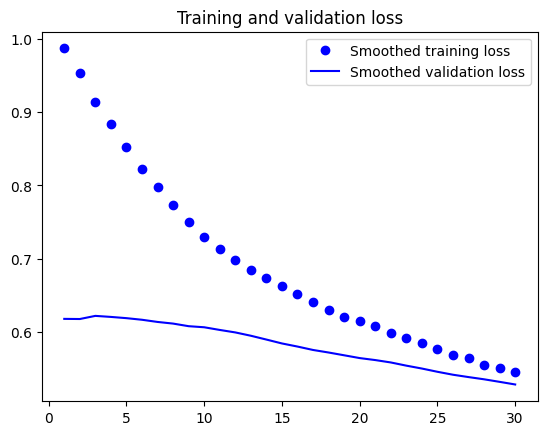

In [12]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting smoothed training and validation accuracy
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plotting smoothed training and validation loss
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

# Display the plots
plt.show()

In [13]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)

print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 21s 418ms/step - loss: 0.5426 - acc: 0.9690
test acc: 0.968999981880188


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)  # Important: shuffle=False to match predictions with labels

# Predicting on test data
test_steps = test_generator.samples // test_generator.batch_size
test_predictions = model.predict(test_generator, steps=test_steps)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions, target_names=['Cat', 'Dog']))


Found 1000 images belonging to 2 classes.
50/50 [==============================] - 23s 439ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.96      0.97      0.97       500
         Dog       0.97      0.96      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



Confusion Matrix:
[[487  13]
 [ 18 482]]


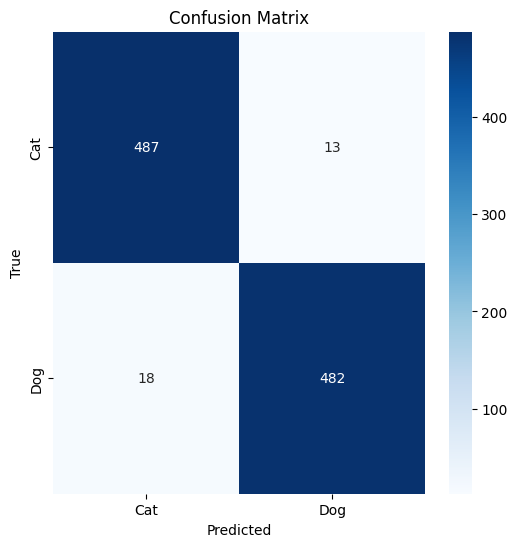

In [15]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


5 models from Xception completed.